[View in Colaboratory](https://colab.research.google.com/github/JohannesFerner/playing-with-tensorflow/blob/master/first.ipynb)

# Playing around with Tensorflow using collab.research.google.com 

In [0]:
import tensorflow as tf
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt


## Goal of this project: 


*   Import Bitcoin price data
*   Clean Data
*   Split in Train+Test Data
*   ... go with the flow ;-)


In [0]:
# Get the data (stored at my github repository)
from io import BytesIO
from zipfile import ZipFile
from urllib.request import urlopen
# or: requests.get(url).content

resp = urlopen('https://raw.githubusercontent.com/JohannesFerner/playing-with-tensorflow/master/data/bitstampUSD_1-min_data_2012-01-01_to_2018-03-27.csv.zip')
zipfile = ZipFile(BytesIO(resp.read()))
filenames = zipfile.namelist()

In [3]:
# Seperate code-container, to be easy on github traffic
df = pd.read_csv(zipfile.open(filenames[0]))
# Convert Unix Timestamp to DateTime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], unit='s')

# Data Exploration
df.info()

print('First Data')
df.head()

print('Latest Data')
df.tail()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 3273377 entries, 0 to 3273376
Data columns (total 8 columns):
Timestamp            datetime64[ns]
Open                 float64
High                 float64
Low                  float64
Close                float64
Volume_(BTC)         float64
Volume_(Currency)    float64
Weighted_Price       float64
dtypes: datetime64[ns](1), float64(7)
memory usage: 199.8 MB
First Data
Latest Data


,Timestamp,Open,High,Low,Close,Volume_(BTC),Volume_(Currency),Weighted_Price
3273372,2018-03-26 23:56:00,8159.21,8159.39,8153.62,8153.68,0.663192,5408.215377,8154.826880
3273373,2018-03-26 23:57:00,8159.38,8163.72,8152.81,8155.00,3.720024,30333.753144,8154.182788
3273374,2018-03-26 23:58:00,8157.47,8158.60,8130.01,8130.01,27.294436,222388.761970,8147.769162
3273375,2018-03-26 23:59:00,8145.17,8149.66,8130.01,8149.66,23.065281,187570.784940,8132.169837
3273376,2018-03-27 00:00:00,8152.26,8164.68,8151.37,8153.04,17.758130,144820.147410,8155.146220


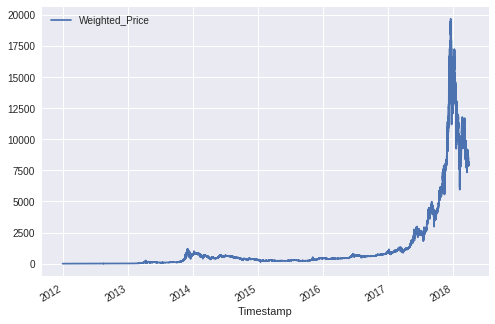

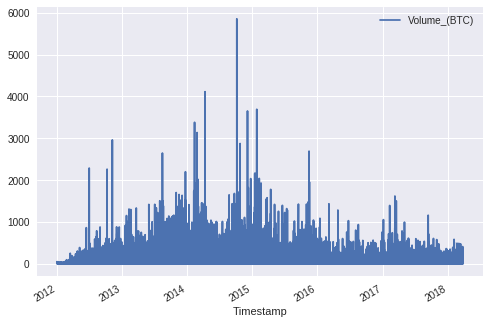

In [4]:
df.plot(y='Weighted_Price', x='Timestamp')
df.plot(y='Volume_(BTC)', x='Timestamp')

In [5]:
# https://colab.research.google.com/notebook#fileId=/v2/external/notebooks/gpu.ipynb&scrollTo=t9ALbbpmY9rm

# Use GPU provided by Colab
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found') # If you have an error go to Runtime -> Change Runtime type -> add GPU acceleration
print('Found GPU at: {}'.format(device_name))



Found GPU at: /device:GPU:0
